<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/cert_prof_time_series/class_02/TS%20-%20W2%20-%2011%20-%20Redes%20neurais%20profundas%20(Laborat%C3%B3rio%203).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Certificado Profissional Desenvolvedor do TensorFlow](https://www.coursera.org/professional-certificates/tensorflow-in-practice) de [Laurence Moroney](https://laurencemoroney.com/)

# Treinamento de uma rede neural profunda com dados de séries temporais

Neste laboratório, você se baseará no exercício anterior e adicionará camadas mais densas à sua rede.

Você também verá uma técnica para ajustar a taxa de aprendizado do modelo e fazer com que os pesos convirjam mais rapidamente.
> Essa é uma dica útil para que você possa evitar "tentar adivinhar" a taxa de aprendizagem antes do treinamento.

As etapas iniciais serão idênticas às do laboratório anterior, portanto, você pode executar as próximas células até a seção `Build the Model`. É aí que começam as discussões.

## Importações

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-12 19:30:06.179340: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 19:30:06.202026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 19:30:06.202052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 19:30:06.202065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 19:30:06.206494: I tensorflow/core/platform/cpu_feature_g

## Utilitários

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualiza dados de séries temporais

    Args:
      time (vetor de int) - contém as etapas de tempo
      series (vetor de int) - contém as medidas para cada etapa de tempo
      format - estilo da linha ao plotar o gráfico
      label - rótulo para a linha
      start - primeiro passo de tempo a ser plotado
      end - última etapa de tempo a ser plotada
    """

    # Configuração das dimensões da figura do gráfico
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plotar os dados da série temporal
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plotar os dados da série temporal
      plt.plot(time[start:end], series[start:end], format)

    # Rotular o eixo x
    plt.xlabel("Tempo")

    # Rotular o eixo y
    plt.ylabel("Valor")

    # Sobrepor uma grade no gráfico
    plt.grid(True)

    # Desenhe o gráfico na tela
    plt.show()

def trend(time, slope=0):
    """
    Gera dados sintéticos que seguem uma linha reta com um valor de inclinação.

    Args:
      time (vetor de int) - contém as etapas de tempo
      slope (float) - determina a direção e a inclinação da linha

    Retorna:
      series (vetor de float) - medições que seguem uma linha reta
    """

    # Calcule a série linear dada a inclinação
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Apenas um padrão arbitrário, você pode alterá-lo se desejar
    
    Args:
      season_time (array of float) - contém as medições por etapa de tempo

    Retorna:
      data_pattern (matriz de float) - contém os valores de medição revisados de acordo com 
                                  de acordo com o padrão definido
    """

    # Gerar os valores usando um padrão arbitrário
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repete o mesmo padrão em cada período

    Args:
      time (vetor de int) - contém as etapas de tempo
      period (int) - número de etapas de tempo antes da repetição do padrão
      amplitude (int) - valor de pico medido em um período
      phase (int) - número de etapas de tempo para deslocar os valores medidos

    Retorna:
      data_pattern (vetor de float) - dados sazonais dimensionados pela amplitude definida
    """
    
    # Definir os valores medidos por período
    season_time = ((time + phase) % period) / period

    # Gera os dados sazonais dimensionados pela amplitude definida
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Gera um sinal ruidoso normalmente distribuído

    Args:
      time (vetor de int) - contém as etapas de tempo
      noise_level (float) - fator de escala para o sinal gerado
      seed (int) - semente do gerador de números para repetibilidade

    Retorna:
      noise (vetor de float) - o sinal ruidoso
    """

    # Inicializar o gerador de números aleatórios
    rnd = np.random.RandomState(seed)

    # Gerar um número aleatório para cada etapa de tempo e dimensionar pelo nível de ruído
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Gerar os dados sintéticos

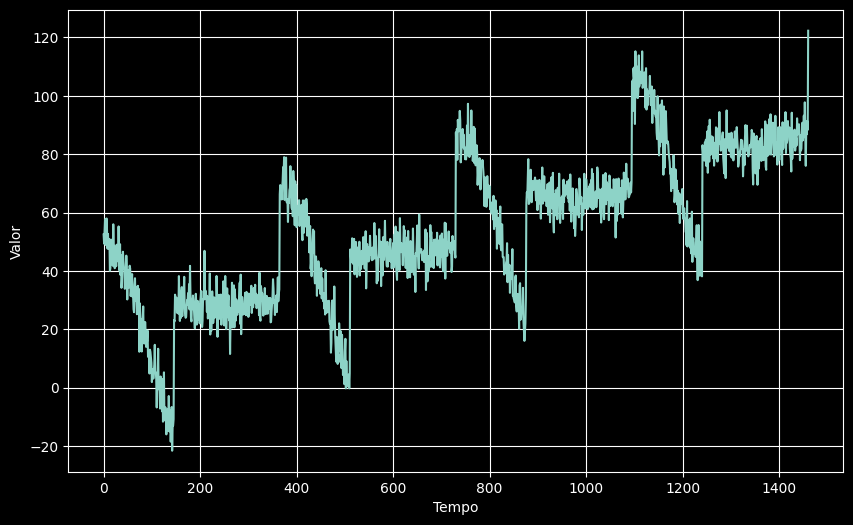

In [5]:
# Hiperparâmetros
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Criar a série
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Atualização com ruído
series += noise(time, noise_level, seed=42)

# Plotar os resultados
plot_series(time, series)

## Dividir o conjunto de dados

In [10]:
# Definir o tempo de divisão
split_time = 1000

# Obter o conjunto de treino 
time_train = time[:split_time]
x_train = series[:split_time]

# Obter o conjunto de validação
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preparar recursos e rótulos

In [6]:
# Hiperparâmetros
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (vetor de float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo para calcular a média
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Retorna:
      dataset (TF Dataset) - Conjunto de dados TF contendo janelas de tempo
    """
  
    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Criar tuplas com recursos e rótulos 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar as janelas
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [11]:
# Gerar as janelas do conjunto de dados
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-04-12 19:32:29.624769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 19:32:29.628074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 19:32:29.628211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Construir o modelo

Você usará três camadas densas neste exercício, conforme mostrado abaixo.

Como esperado, o número de parâmetros treináveis aumentará e o resumo do modelo mostra que ele é mais de dez vezes maior que o do laboratório anterior.

In [12]:
# Construir o modelo
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Imprimir o resumo do modelo
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Treinar o modelo

Em seguida, você compilará e treinará o modelo usando as mesmas configurações anteriores.

Observe como a perda está diminuindo, pois você voltará a ela mais tarde neste laboratório.

In [13]:
# Definir os parâmetros de treinamento
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [14]:
# Treinar o modelo
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
      1/Unknown - 1s 663ms/step - loss: 3102.5833

2024-04-12 19:33:39.371987: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7aff6c008f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 19:33:39.372008: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-12 19:33:39.376912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-12 19:33:39.412982: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 1s 2ms/step - loss: 665.4972
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 105.4576
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 89.0339
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 85.4056
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 81.7368
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 78.5824
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 75.8461
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 75.0449
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 72.2282
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 69.9044
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 68.3477
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 67.2650
Epoch 13/100
31/31 [===============

Em seguida, você pode obter algumas previsões e visualizá-las como antes. Como a rede é mais profunda, as previsões podem ser mais lentas, portanto, convém minimizar os cálculos desnecessários. 

No laboratório anterior, você deve se lembrar que o modelo gerou previsões usando todos os dados da `série`. Isso resultou em 1.441 pontos na lista `forecast` e, em seguida, você cortou os 461 pontos que se alinham com o conjunto de validação usando `forecast = forecast[split_time - window_size:]`. 

Você pode agilizar esse processo gerando apenas 461 pontos desde o início. Dessa forma, você não perde tempo prevendo pontos que serão jogados fora mais tarde. O código abaixo fará exatamente isso. Ele apenas obterá os pontos necessários da `série` original antes de chamar o método `predict()`. Com isso, todas as previsões já estarão alinhadas com o conjunto de validação e o loop for será executado apenas 461 vezes em vez de 1.441. 

No próximo laboratório, você verá uma maneira ainda mais rápida de gerar essas previsões.

1/1 [==============================] - 0s 10ms/step


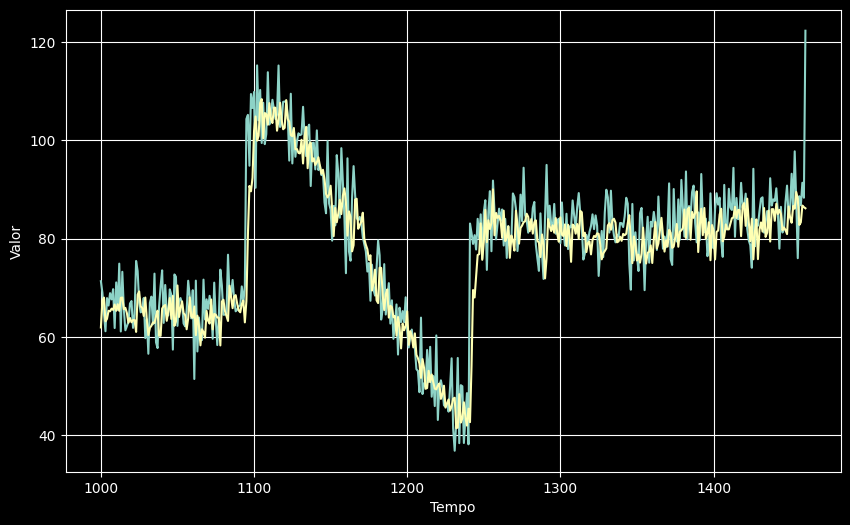

In [15]:
# Inicializar uma lista
forecast = []

# Reduzir a série original
forecast_series = series[split_time - window_size:]

# Use o modelo para prever pontos de dados por tamanho de janela
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Converta em uma matriz numérica e elimine os eixos de dimensão única
results = np.array(forecast).squeeze()

# Plotar os resultados
plot_series(time_valid, (x_valid, results))

Em seguida, você pode obter o MSE e o MAE como referência.

In [16]:
# Calcular as métricas
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

49.49287
5.126513


## Ajuste a taxa de aprendizado

Você viu que o treinamento correu bem com a taxa de aprendizado inicial que escolheu (ou seja, `1e-6`).
> Entretanto, você ainda não tem certeza se essa é a melhor configuração para esse modelo específico.

Isso pode parecer irrelevante nesse modelo simples, mas quando você tem modelos mais complexos, dedicar algum tempo para ajustar a taxa de aprendizagem pode levar a melhores resultados de treinamento. Você verá como fazer isso nesta seção.

Primeiro, você criará a mesma arquitetura de modelo que acabou de usar.

In [17]:
# Criar o modelo
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

Em seguida, você declarará um _callback_ [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).

Isso permitirá que você defina dinamicamente a taxa de aprendizagem com base no número da época durante o treinamento. 

Conforme mostrado abaixo, você passará uma função lambda para declarar o valor da taxa de aprendizado.

Ela começará em `1e-8` na época 0 e será escalonada em `10**(época / 20)` à medida que o treinamento prossegue.

In [18]:
# Definir o agendador de taxa de aprendizado
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

Em seguida, você compilará o modelo.

Não é necessário definir o argumento `learning_rate` do otimizador aqui antes da compilação:
* Você pode simplesmente deixa o padrão (ou seja, [`0.01` para SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) e permite que o agendador da taxa de aprendizado a defina dinamicamente.

In [19]:
# Inicializar o otimizador
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Definir os parâmetros de treino
model_tune.compile(loss="mse", optimizer=optimizer)

Você passará o _callback_ `lr_schedule` no parâmetro `callbacks` do método [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

Ao executar o treinamento abaixo, você verá a taxa de aprendizado em uma determinada época denotada por `lr` na saída do console.

Observe que ela está aumentando conforme o esperado com base na função lambda que você usou.

In [20]:
# Treine o modelo
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 3086.0352 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 2791.7048 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 2541.8350 - lr: 1.2589e-08
Epoch 4/100


2024-04-12 19:39:22.332280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11075283126580755131
2024-04-12 19:39:22.332348: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13855541982075900633
2024-04-12 19:39:22.332377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2769987562864287249
2024-04-12 19:39:22.332385: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 523367652463108025


31/31 [==============================] - 0s 1ms/step - loss: 2366.0537 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 2219.4424 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 2072.9570 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 1916.5702 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 1741.2249 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 1539.0920 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 1303.4291 - lr: 2.8184e-08
Epoch 11/100
31/31 [==============================] - 0s 989us/step - loss: 1035.3710 - lr: 3.1623e-08
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 749.9363 - lr: 3.5481e-08
Epoch 13/100
31/31 [==============================] - 0s 1ms/step - loss: 490.8841 - lr: 3.9811e-08
Epoch 14

A próxima etapa é plotar os resultados do treinamento.

Você visualizará a perda em cada valor da taxa de aprendizado.

(1e-08, 0.001, 0.0, 300.0)

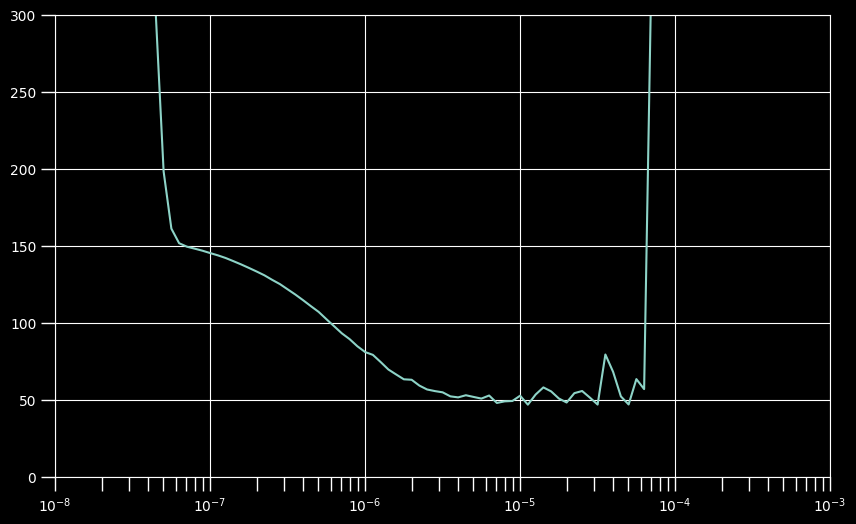

In [24]:
# Definir a matriz de taxa de aprendizado
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Definir a grade
plt.grid(True)

# Plotar a perda em escala logarítmica
plt.semilogx(lrs, history.history["loss"])

# Aumentar o tamanho dos tickmarks
plt.tick_params('both', length=10, width=1, which='both')

# Definir os limites do gráfico
plt.axis([1e-8, 1e-3, 0, 300])

O gráfico gerado acima mostra os valores do intervalo de taxas de aprendizado que levam a perdas menores (ou seja, inclinadas para baixo) e também quais fazem com que o treinamento se torne instável (ou seja, bordas irregulares e apontando para cima).

*Em geral, você deve escolher um ponto em uma inclinação descendente.*
> Isso significa que a rede ainda está aprendendo nesse ponto e é estável.

A escolha de um ponto próximo ao ponto mínimo do gráfico fará com que o treinamento convirja para esse valor de perda mais rapidamente, como será mostrado nas próximas células.

Primeiro, você inicializará a mesma arquitetura de modelo novamente.

In [25]:
# Construir o modelo
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

Em seguida, você definirá o otimizador com uma taxa de aprendizado próxima ao mínimo.

Ela é definida inicialmente como `4e-6`, mas fique à vontade para alterá-la com base em seus resultados.

In [26]:
# Definir o otimizador com a taxa de aprendizado ajustada
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

Em seguida, você pode compilar e treinar o modelo como antes.

Observe os valores de perda e compare-os com a saída do modelo de linha de base que você tinha antes.
> Muito provavelmente, você terá atingido o valor de perda final do `model_baseline` nas primeiras 50 épocas de treinamento desse `model_tune`.

Também é provável que você tenha uma perda menor depois que todas as 100 épocas forem concluídas.

In [27]:
# Definir os parâmetros de treinamento
model_tune.compile(loss="mse", optimizer=optimizer)

# Treinar o modelo
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 417.9505
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 76.7317
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 68.9566
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 66.5195
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 65.5332
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 62.1344
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 61.3527
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 59.9650
Epoch 9/100
31/31 [==============================] - 0s 994us/step - loss: 58.8816
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 58.2364
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 56.5065
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 56.1424
Epoch 13/100
31/31 [==

Você pode plotar os valores de `perda` obtendo-os do objeto [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) retornado pelo método `fit()`.

Como você pode ver, o modelo ainda está tendendo para baixo após o treinamento.

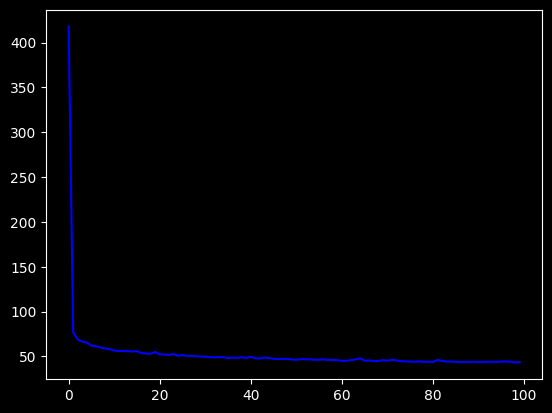

In [28]:
# Plotar a perda
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

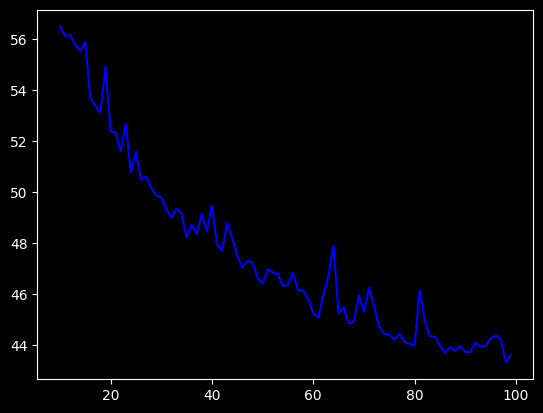

In [29]:
# Plotar todos os dados, exceto os 10 primeiros
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

Você pode obter as previsões novamente e sobrepô-las ao conjunto de validação.

1/1 [==============================] - 0s 11ms/step


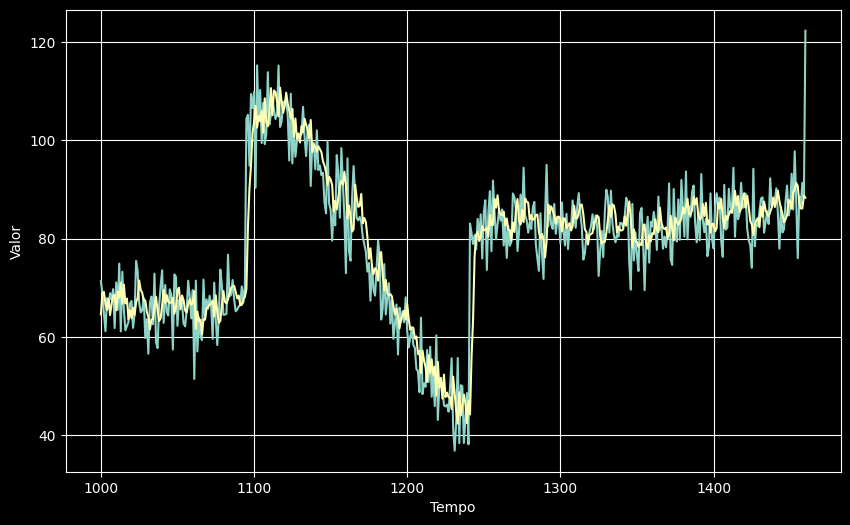

In [30]:
# Inicializar uma lista
forecast = []

# Reduzir a série original
forecast_series = series[split_time - window_size:]

# Use o modelo para prever pontos de dados por tamanho de janela
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Converta em uma matriz numérica e elimine os eixos de dimensão única
results = np.array(forecast).squeeze()

# Plotar os resultados
plot_series(time_valid, (x_valid, results))

Por fim, você pode calcular as métricas e deve chegar a números semelhantes em comparação com a linha de base.

Se for muito pior, então o modelo pode ter sido ajustado em excesso(_overfitting_) e você pode usar técnicas que conhece para evitar isso (por exemplo, adicionar _dropout_).

In [31]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.81256
4.9916754


## Encerramento

Isso conclui o exercício sobre o uso de uma rede neural profunda para previsão.

Ao longo do caminho, você fez alguns ajustes de hiperparâmetros, principalmente na taxa de aprendizado.

Você também usará essa técnica nos próximos laboratórios.

No próximo você usará redes neurais recorrentes para criar seu modelo de previsão.

Continue assim!